In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

<span style="color: red;">
<div dir='rtl'>

<b> نام و نام‌‌خانوادگی: سید احسان حسن بیگی</b>

<b> شماره دانشجویی: ۴۰۲۲۱۱۷۲۳</b>

</span>

<div dir='rtl'>
<h1> 
مقدمه
</h1>
<p>
در این تمرین قصد داریم به مباحث زیر بپردازیم:
<li> کاهش ابعاد </li>
<li> خوشه‌بندی متن و هرس‌کردن خوشه‌ها</li>

کتابخانه‌های مورد نظرتان را هم می‌توانید در اولین سل نوت‌بوک فراخوانی کنید. 

تمرین درباره ی خوشه بندی اهنگ های مشابه در اپ اسپاتیفای است که از دیتاستی از سایت کگل برداشته شده است.
</p>
</div>

<div dir="rtl">
<h1>
لود دیتا</h1>
</div>

<div dir="rtl">
در این بخش باید دیتا را لود کرده و در انتها فقط نام آهنگ و فیچر هایی که به نظرتان مفید است را با ذکر علتی کوتاه نگه دارید. 
</div>

First we will load the raw data and do some basic preprocessings. In this case we did the following:
- dropped samples which had null values
- merged the samples corresponding to the same song

In [2]:
raw_data = pd.read_csv("datasets/spotify.csv")
raw_data = raw_data.dropna()

# merge rows with the same 'track_id'
# replace numeric columns with the mean
# replace non-numeric columns with the most frequent value
# numeric_columns = raw_data.select_dtypes(include=["number"]).columns.tolist()
# non_numeric_columns = raw_data.select_dtypes(exclude=["number"]).columns.tolist()
# raw_data = raw_data.groupby("track_id", as_index=False).agg(
#     {
#         **{col: "mean" for col in numeric_columns},
#         **{col: lambda x: x.mode().iloc[0] for col in non_numeric_columns},
#     }
# )

Here, we are eliminating certain columns that do not contribute to clustering:
- all ID columns are excluded as they consist of random strings. They especially hurt our performance due to providing a distinct value for each sample, hence increasing the varaince of the feature.
- all columns displaying names are excluded because they represent distinct values like IDs. (It's worth noting that such features would be beneficial if we were to use some sort of word embeddings, but in this context, they do not contribute meaningfully)
- release date of the song is also excluded, as it does not provide relevant information about the actual song

Another necessary step is to transform categorical features into numeric features, as PCA operates exclusively with numeric features. An important note here is that employing one-hot encoding for this conversion is not viable. One-hot encoding would drastically increase the number of features, contradicting the whole purpose of using PCA, which is to reduce the dimensionality. Moreover, PCA does not perform well with one-hot columns because sparse boolean values increase the variance along their axes.
So we are going to use label encoding.

In [3]:
garbage_cols = ["track_id", "track_album_id", "playlist_id", "playlist_name", "track_album_release_date",
                "track_name", "track_album_name", "playlist_subgenre", "track_artist"]

le_data = raw_data.copy().drop(columns=garbage_cols, axis=1)
non_numeric_columns = le_data.select_dtypes(exclude=["number"]).columns.tolist()
for col in non_numeric_columns:
    le = preprocessing.LabelEncoder()
    le_data[col] = le.fit_transform(le_data[col])

<div dir="rtl">
توضیح دهید که دیتای scale نشده چه مشکلی میتواند برای خوشه بندی ایجاد کند?
<br>
در این cell باید یک standard scalar را از صفر پیاده سازی نمایید. تا برای قسمت های بعدی یک دیتای مناسب داشته باشید.
</div>

Using non-normalized data can hurt the performance of the model. This is especially important in our case where the model relies on distances. If we don't normalize the data, one feature may have significantly larger scale than others, leading it to dominate distance measurements against all other features and disproportionately influencing distance calculations.
To address this issue, we implement standardization as our normalization technique:

In [4]:
def standardize(df, numeric_columns=None):
    if numeric_columns is None:
        numeric_columns = df.select_dtypes(include=["number"]).columns.tolist()

    column_stats = {}
    for col in numeric_columns:
        mean = df[numeric_columns][col].mean()
        std = df[numeric_columns][col].std()
        column_stats[col] = {'mean': mean, 'std': std}

        df[col] = (df[col] - mean) / std

    return df, column_stats

<div dir="rtl">
<h1>
کاهش ابعاد
</h1>
</div>

<div dir="rtl">
یکی از روش‌های کاهش ابعاد، PCA است. با استفاده از پیاده‌سازی آن در کتابخانه sklearn، ابعاد ویژگی‌ را کاهش دهید.
<br>
سپس با استفاده از explained_variance_ratio_ در الگوریتم PCA  نشان دهید که با وجود یک ترشولد مناسب  تا چه میزان میتوان ابعاد ویژگی ها را کم تر کرد.
<br>
برای ترشولدی که انتخاب کردید دلیل بیاورید و شهود این متغیر را توضیح دهید.
</div>

A trade-off exists between reducing feature dimensionality and preserving the original information. PCA tries to find new axes called principal components that capture the highest variance in the data. The principal components are ordered by the amount of variance they capture. The explained_variance_ratio_ gives the fraction of the total variance that each principal component represents. This information is useful for understanding how much variance (information) is retained by each component.

The variance for each PC is shown in the plot below. So we can calculate the accumulated variance and choose our threshold based on the amount of variance we want to preserve. In our case we chose two PCs because the gaps keep getting smaller after the first two PCs and we get diminishing returns.
Another reason is that we want to be able to plot the clustering in 2D :)

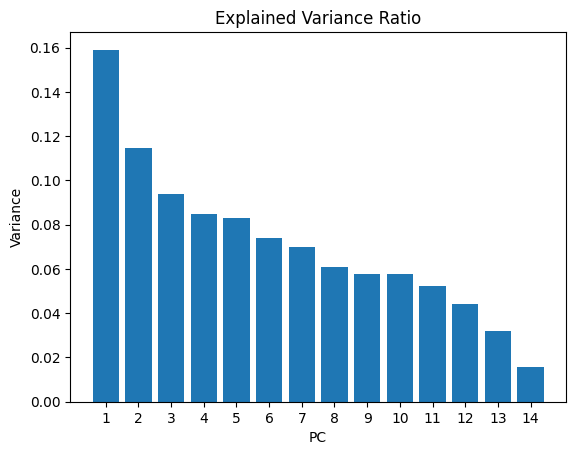

We chose 2 principal componentes
Explained variance ratio for each PC:
[0.15906811 0.11447319]


In [5]:
def reduce_dimension(embedding, n_components=None):
    pca = PCA(n_components)
    pca.fit(embedding)
    return pca.transform(embedding), pca.explained_variance_ratio_


normalized_data, _ = standardize(le_data)
_, evr = reduce_dimension(normalized_data)
plt.bar(range(1, len(evr) + 1), evr)
plt.title("Explained Variance Ratio")
plt.xlabel("PC")
plt.ylabel("Variance")
plt.xticks(range(1, len(evr) + 1))
plt.show()

# threshold = 0.2
latent_data, evr = reduce_dimension(normalized_data, 0.2)
print(f"We chose {len(evr)} principal componentes")
print(f"Explained variance ratio for each PC:\n{evr}")

<div dir="rtl">
<h2>
خوشه‌بندی
</h2>
</div>

<div dir="rtl">
در این قسمت، شما ابتدا الگوریتم خوشه‌بندی K-means را 
<u><b>از پایه</b></u>
 پیاده‌سازی می‌کنید.

</div>

In [6]:
class KMeans:
    def __init__(self, n_clusters, max_steps=100, random_state=None):
        self.n_clusters = n_clusters
        self.max_steps = max_steps
        self.random_state = random_state
        self.centroids = None
        self.cluster_indices = None

    def fit(self, X):
        np.random.seed(self.random_state)

        # randomly initialize centroids
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        for _ in range(self.max_steps):
            self.cluster_indices = self.__get_new_clusters(X)
            new_centroids = self.__get_new_centroids(X)

            # check for convergence
            if np.all(new_centroids == self.centroids):
                break

            self.centroids = new_centroids

        return self.centroids, self.cluster_indices

    def __get_new_clusters(self, X):
        # adding new axis to calculate distances of each data point w.r.t all centroids
        distances = np.linalg.norm(X[:, np.newaxis, :] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

    def __get_new_centroids(self, X):
        new_centroids = np.array(
            [X[self.cluster_indices == k].mean(axis=0) for k in range(self.n_clusters)]
        )
        return new_centroids

    def calc_wss(self, X):
        wss = 0
        for i in range(len(self.centroids)):
            cluster_points = X[self.cluster_indices == i]
            wss += np.sum((cluster_points - self.centroids[i]) ** 2)
        return wss

    def calc_silhouette_score(self, X):
        if self.cluster_indices is None:
            raise ValueError("Fit the model before calculating the silhouette score.")

        silhouette_scores = []

        for i in range(len(X)):
            a_i = self.__calc_avg_dist_within_cluster(i, X)
            b_i = self.__calc_avg_dist_to_other_clusters(i, X)

            silhouette_score_i = (b_i - a_i) / max(a_i, b_i)
            silhouette_scores.append(silhouette_score_i)

        return np.mean(silhouette_scores)

    def __calc_avg_dist_within_cluster(self, i, X):
        cluster_points = X[self.cluster_indices == self.cluster_indices[i]]
        distances = np.linalg.norm(cluster_points - X[i], axis=1)
        return np.mean(distances)

    def __calc_avg_dist_to_other_clusters(self, i, X):
        other_clusters = set(np.unique(self.cluster_indices)) - {
            self.cluster_indices[i]
        }
        min_avg_distance = float("inf")

        for cluster in other_clusters:
            cluster_points = X[self.cluster_indices == cluster]
            distances = np.linalg.norm(cluster_points - X[i], axis=1)
            avg_distance = np.mean(distances)
            min_avg_distance = min(min_avg_distance, avg_distance)

        return min_avg_distance

    # this method only works for 2D feature spaces
    def visualize(self):
        for k in range(self.n_clusters):
            cluster_points = latent_data[self.cluster_indices == k]
            plt.scatter(
                cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {k + 1}"
            )

        plt.scatter(
            self.centroids[:, 0],
            self.centroids[:, 1],
            c="red",
            marker="X",
            label="Centroids",
        )

        plt.title(f"K-Means with k={self.n_clusters}")
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.legend()
        plt.show()

<div dir="rtl">
 با استفاده از K-Means خوشه‌ها را ایجاد کنید. الگوریتم را با استفاده از چند مقدار مختلف تعداد خوشه‌ها (k) اجرا کنید. در هربار اجرا، با استفاده از تعدادی از اسناد موجود در هر خوشه، موضوع آن خوشه را تعیین کرده و خوشه‌بندی حاصله را با استفاده از بردار‌های دوبعدی قسمت قبل، رسم کنید. با اینکار، پیاده‌سازی خود و همچنین کارایی این الگوریتم در خوشه‌بندی اسناد و قرار دادن اسناد مشابه در خوشه‌های یکسان را بررسی کنید.
<br>

 نمودار silhouette score برای مقدار‌های مختلف k را رسم کرده و silhouette analysis برای انتخاب k مناسب انجام دهید. 
<br>
همچنین Within-Cluster Sum of Squares (WSS) را نیز محاسبه کرده و در نهایت این دو کار بهترین مقدار k  را بدست بیاورید.
</div>

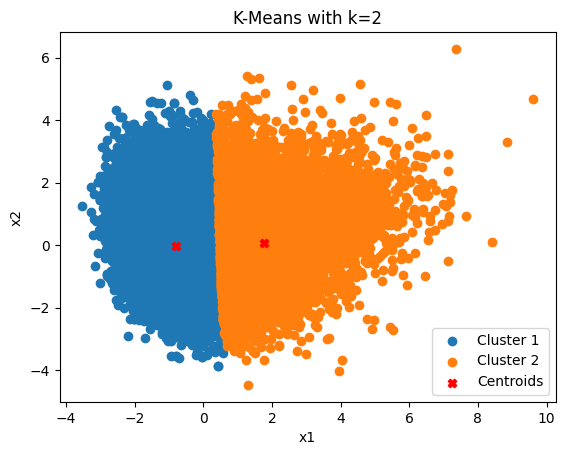

Genre of cluster 1: edm
Genre of cluster 2: r&b




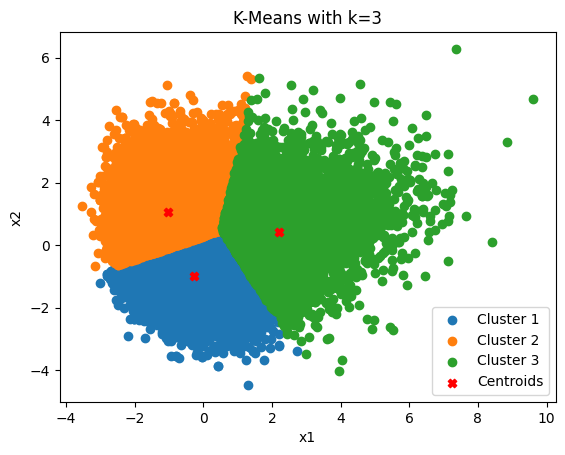

Genre of cluster 1: latin
Genre of cluster 2: edm
Genre of cluster 3: r&b




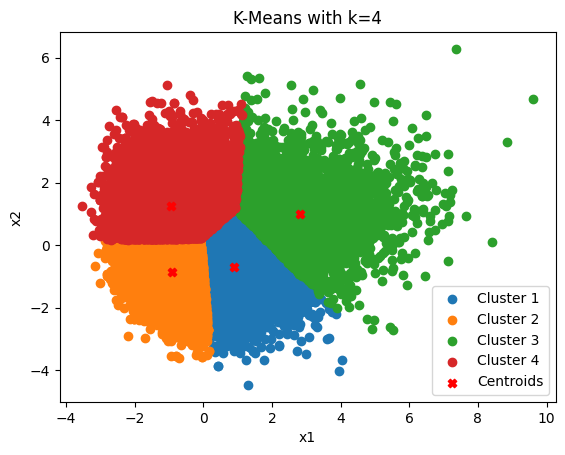

Genre of cluster 1: rap
Genre of cluster 2: latin
Genre of cluster 3: r&b
Genre of cluster 4: edm




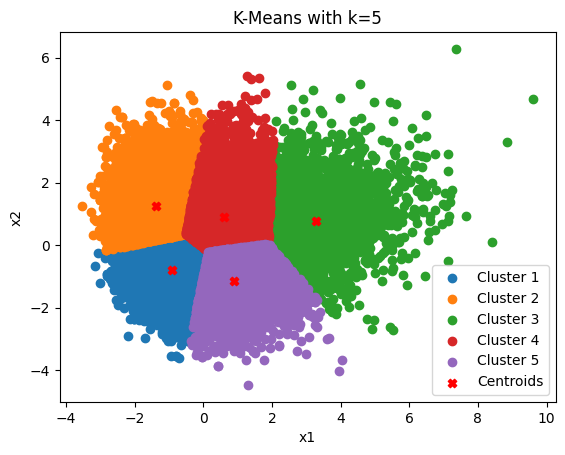

Genre of cluster 1: latin
Genre of cluster 2: edm
Genre of cluster 3: r&b
Genre of cluster 4: rock
Genre of cluster 5: rap




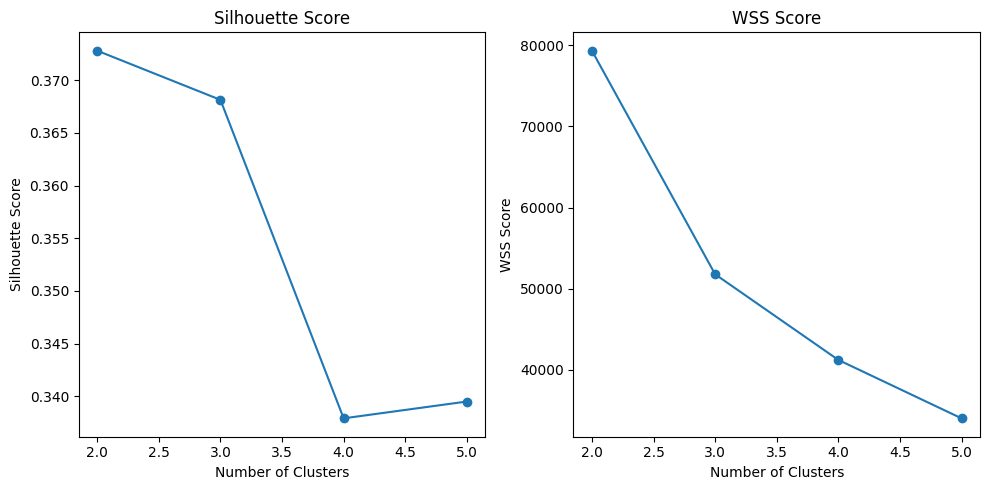

In [8]:
max_cluster_count = 5
# n_clusters starts from 2 because silhouette score is not defined for less
cluster_range = range(2, max_cluster_count + 1)
silhouette_scores, wss_scores = [], []
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    _, final_cluster_indices = kmeans.fit(latent_data)

    kmeans.visualize()
    for i in range(n_clusters):
        most_frequent_genre = raw_data[final_cluster_indices == i]['playlist_genre'].value_counts().idxmax()
        print(f"Genre of cluster {i+1}: {most_frequent_genre}")
    print("\n")
    # silhouette_scores.append(kmeans.calc_silhouette_score(latent_data))
    wss_scores.append(kmeans.calc_wss(latent_data))

    # you can use sklearn's silhouette score for faster calculations:
    silhouette_scores.append(silhouette_score(latent_data, final_cluster_indices))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(cluster_range, silhouette_scores, marker="o")
axes[0].set_xlabel("Number of Clusters")
axes[0].set_ylabel("Silhouette Score")
axes[0].set_title("Silhouette Score")

axes[1].plot(cluster_range, wss_scores, marker="o")
axes[1].set_xlabel("Number of Clusters")
axes[1].set_ylabel("WSS Score")
axes[1].set_title("WSS Score")

plt.tight_layout()
plt.show()

<div dir="rtl">
با استفاده از نمودارهای رسم شده توضیح دهید بهترین k برای انتخاب در داده ما با استفاده از الگوریتم K-Means چیست؟
چرا؟
</div>

Selecting the optimal number of clusters for a clustering algorithm involves evaluating metrics like the silhouette score and WSS:
- silhouette score quantifies the similarity of data points within their assigned clusters, with a higher score indicating better clustering
- WSS measures the compactness of clusters by summing the squared distances between data points and their cluster centroids, with a lower score indicating better clustering

Our way of selection is to plot the silhouette score and WSS for various cluster numbers. Then we will select the point with highest silhouette score that also has a relatively low WSS. So for our case, we will select k=3

<div dir="rtl">
<h2>
بررسی خروجی</h2>
</div>

<div dir="rtl">
در این قسمت برای اینکه ببینیم چقدر خوب خوشه بندی را انجام داده ایم, از یک روش sample check و نیز TSNE استفاده خواهیم کرد.

</div>

<div dir="rtl">
در ابتدا به صورت رندوم از هر خوشه دو اهنگ را انتخاب کرده (با توجه به اینکه در بخش اول بایستی اسم اهنگ را نیز نگه میداشتید) و ببینید واقعا این اهنگ ها به هم نزدیک هستند یا خیر.
نکته اینکه صرفا بررسی این عمل نمره دارد و نیازی به خیلی دقیق بودن خروجی نیست.
</div>

In [ ]:
# TODO: Sample 2 songs from each cluster and compare them.

<div dir="rtl">
با استفاده از این T-SNE و کاهش ابعاد به 2 بعد نشان دهید که ایا خوشه بنده به خوبی انجام شده است یا خیر.

</br>
در صورت پیاده سازی تابع tsne  از ابتدا, نمره ی امتیازی به شما تعلق خواهد گرفت.
</div>

In [ ]:
# TODO: Visualize the clusters 

In [ ]:
# Bonus TODO: Implement TSNE from scratch